### This notebook demonstrates the alternative DCTR fitting method applied on Lund jet datasets

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import numpy as np

In [3]:
# standard library imports
from __future__ import absolute_import, division, print_function

import keras

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import keras.backend as K
import pickle

Using TensorFlow backend.
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflo

In [4]:
import tensorflow as tf

In [5]:
import matplotlib.pyplot as plt

## Utilities

In [6]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [7]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

In [8]:
# network architecture parameters
Phi_sizes = (100,100, 128)
F_sizes = (100,100, 100)

dctr = PFN(input_dim=7, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=True)

#load model from saved file
dctr.model.load_weights('./saved_models/DCTR_ee_dijets_1D_aLund.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 7)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    800         input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_1[0][0]               
__________________________________________________________________________________________________
activation

In [9]:
test_dataset_0 = np.load('test1D_default.npz')
test_dataset_1 = np.load('test1D_aLund.npz')

In [10]:
dctr

In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5834711740029536174
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10913290650
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14407887727639847784
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:0a:00.0, compute capability: 6.1"
]


## Load Data

In [12]:
X_default = preprocess_data(test_dataset_0['jet'][:,:,:])
X_unknown = preprocess_data(test_dataset_1['jet'][:,:,:])

Y_default = np.zeros_like(X_unknown[:,0,0])
Y_unknown = np.ones_like(X_unknown[:,0,0])

In [13]:
X_fit = np.concatenate((X_default, X_unknown), axis = 0)

Y_fit = np.concatenate((Y_default, Y_unknown), axis = 0)
Y_fit = to_categorical(Y_fit, num_classes=2)

In [14]:
X_fit, _, Y_fit, _ = data_split(X_fit, Y_fit, test=0, shuffle=True)

# Fitting

## Loss Curve Model

In [15]:
class AddParams2Input(keras.layers.Layer):
    """ Custom layer for tuning with DCTR: 
    Arguments:
    - n_MC_params : (int) - the number of n_MC_params that are in X_dim
    - default_MC_params : (list of floats) - default values for each of the MC parameters
    - trainable_MC_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Usage: 
    Let X_dim be the input dimension of each particle to a PFN model, and n_MC_params be the number of MC parameters. 
    Defines a Layer that takes in an array of dimension 
    (batch_size, padded_multiplicity, X_dim - n_MC_params)
    This layer appends each particle by the default_MC_params and makes then trainable or non-trainable based on trainable_MC_params
    """
    
    def __init__(self, n_MC_params, default_MC_params, trainable_MC_params):
        super(AddParams2Input, self).__init__()
        # Definitions
        self.n_MC_params = n_MC_params
        self.MC_params = default_MC_params
        self.trainable_MC_params = trainable_MC_params

    
    def build(self, input_shape):
        # Convert input MC parameters to weights and make then trainable or non-trainable
        for i in range(self.n_MC_params):
            self.MC_params[i] = self.add_weight(name='MC_param_{}'.format(i), 
                                                shape=(1, 1),
                                                initializer=keras.initializers.Constant(self.MC_params[i]),
                                                trainable=self.trainable_MC_params[i])
            
        self.MC_params = keras.backend.tf.concat(self.MC_params, axis = -1)
        super(AddParams2Input, self).build(input_shape)
    
    def call(self, input):
        # Add MC params to each input particle (but not to the padded rows)
        concat_input_and_params = keras.backend.tf.where(keras.backend.abs(input[...,0])>0,
                                                         self.MC_params*keras.backend.ones_like(input[...,0:self.n_MC_params]),
                                                         keras.backend.zeros_like(input[...,0:self.n_MC_params]))
        return keras.backend.concatenate([input, concat_input_and_params], -1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]+self.n_MC_params)

In [16]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import variables as variables_module

def _backtrack_identity(tensor):
    while tensor.op.type == 'Identity':
        tensor = tensor.op.inputs[0]
    return tensor

def my_loss_wrapper():
    def my_loss(y_true,y_pred):
        target = y_true
        output = y_pred
        axis = -1
        from_logits = False
        target.shape.assert_is_compatible_with(output.shape)
        if from_logits:
            return nn.softmax_cross_entropy_with_logits_v2(
                labels=target, logits=output, axis=axis)

        if not isinstance(output, (ops.EagerTensor, variables_module.Variable)):
            output = _backtrack_identity(output)
            if output.op.type == 'Softmax':
                # When softmax activation function is used for output operation, we
                # use logits from the softmax function directly to compute loss in order
                # to prevent collapsing zero when training.
                # See b/117284466
                assert len(output.op.inputs) == 1
                output = output.op.inputs[0]
                return nn.softmax_cross_entropy_with_logits_v2(
                  labels=target, logits=output)

        # scale preds so that the class probas of each sample sum to 1
        output = output / math_ops.reduce_sum(output, axis, True)
        # Compute cross entropy from probabilities.
        epsilon_ = _constant_to_tensor(epsilon(), output.dtype.base_dtype)
        output = clip_ops.clip_by_value(output, epsilon_, 1. - epsilon_)
        return -math_ops.reduce_sum(target * math_ops.log(output), axis)
    return my_loss

In [17]:
def get_DCTR_fit_model(DCTR_model, 
                       X_dim, 
                       n_MC_params, 
                       default_MC_params,
                       trainable_MC_params):
    """ 
    Get a DCTR model that trains on the input MC parameters
    
    Arguments:
    - DCTR_model : a PFN model that has been trained on a to continuously interpolate over the input MC dimensions
    - X_dim : (int) - the dimension of the input expected by DCTR_model
    - n_MC_params : (int) - the number of n_MC_params that are in X_dim
    - default_MC_params : (list of floats) - default values for each of the MC parameters
    - trainable_MC_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Returns:
    - DCTR_fit_model: a compiled model that gradient descends only on the trainable MC parameters
    """
    
    # Do sanity checks on inputs
    assert X_dim >=n_MC_params, "X_dim must be larger than n_MC_params. X_dim includes the dimensionality of the 4-vector + number of MC parameters"
    assert n_MC_params == len(default_MC_params), "Dimension mismatch between n_MC_params and number of default MC parameters given. len(default_MC_params) must equal n_MC_params"
    assert n_MC_params == len(trainable_MC_params), "Dimension mismatch between n_MC_params and trainable_MC_params. len(trainable_MC_params) must equal n_MC_params."
    assert np.any(trainable_MC_params), "All parameters are set to non-trainable."
    
    # Define input to DCTR_fit_model
    non_param_input = keras.layers.Input((None, X_dim - n_MC_params))

    # Construct layer that adds trainable and non-trainable parameters to the input
    add_params_layer = AddParams2Input(n_MC_params, default_MC_params, trainable_MC_params)
    time_dist     = keras.layers.TimeDistributed(add_params_layer, name='tdist')(non_param_input)     

    # Set all weights in DCTR_model to non-trainable
    for layer in DCTR_model.model.layers:
        layer.trainable = False
        
    # get the graph and the weights from the DCTR_model
    output = DCTR_model.model(inputs = time_dist)

    # Define full model
    DCTR_fit_model = fitmodel = keras.models.Model(inputs = non_param_input, outputs = output)
    optimizer = keras.optimizers.Adam(lr=1e-4)
    # Compile with loss function
    DCTR_fit_model.compile(optimizer=optimizer, loss=my_loss_wrapper())
    
    
    return DCTR_fit_model

In [18]:
def set_MC_params(dctr_fit_model, MC_params):
    alphaS, aLund, StoUD = MC_params
    weights = [np.array([[alphaS]],   dtype=np.float32),
               np.array([[aLund]],    dtype=np.float32),
               np.array([[StoUD]], dtype=np.float32)]
    dctr_fit_model.layers[1].set_weights(weights)

In [19]:
def get_loss(X, Y, dctr_fit_model, MC_params, batch_size = 1000):
    set_MC_params(dctr_fit_model, MC_params)
    return dctr_fit_model.evaluate(x=X, y = Y, batch_size=batch_size)

In [20]:
dctr_fit_model = get_DCTR_fit_model(dctr, 
                       X_dim =7, 
                       n_MC_params = 3, 
                       default_MC_params   = [0.1365, 0.68, 0.217], # default params for [alpha_s, aLund, StoUD]
                       trainable_MC_params = [False, True, False]) # Only train aLund

### Define neural network g

In [21]:
from keras.layers import Lambda, Dense, Input, Layer, Dropout, Dot, Flatten
from keras.models import Model

### Pre Calculate DCTR Weight 

In [22]:
def replace_weight(X_fit_slice,theta):
    for i in range(len(X_fit_slice)):
        for j in range(len(X_fit_slice[i,:,:])):
            if (X_fit_slice[i,j,5]!=0):
                X_fit_slice[i,j,5] = theta
    return X_fit_slice

In [23]:
thetas = np.linspace(0.6,0.9,20)
num_data_test = 10000
predicted_weight_list = []
X_fit_replace_weight_list = []
X_val_replace_weight_list = []
for i in range(len(thetas)):
    theta = thetas[i]
    X_fit_replace_weight = replace_weight(X_fit[:num_data_test],theta)
    X_fit_replace_weight_list.append(X_fit_replace_weight)
    X_val_replace_weight = replace_weight(X_fit[-num_data_test:],theta)
    X_val_replace_weight_list.append(X_val_replace_weight)
    predicted_weight_list.append(dctr.predict(X_fit_replace_weight))

### Fitting the neural network g (DNN Model) and scan for theta with maximum loss

In [24]:
myinputs = Input(shape=(357,))

x = Dense(128, activation='relu')(myinputs)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=myinputs, outputs=predictions)
model.summary()

def my_loss_wrapper(weight,val=0.0):
            
    theta0 = val #target value 
    def my_loss(y_true,y_pred):
        print("y_true shape", y_true.shape)
        print("y_pred shape", y_pred.shape)
        t_loss = y_true*(y_true - y_pred)**2+(weight)*(1.-y_true)*(y_true - y_pred)**2
        return K.mean(t_loss)
        #return tf.convert_to_tensor(1.0)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 357)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               45824     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 62,465
Trainable params: 62,465
Non-trainable params: 0
_________________________________________________________________


In [25]:

lvals = []
for i in range(len(thetas)):
    print(thetas[i])
    theta = thetas[i]
    predicted_weight = predicted_weight_list[i]
    X_fit_replace_weight = X_fit_replace_weight_list[i]
    X_val_replace_weight = X_val_replace_weight_list[i]    
    model.compile(optimizer='adam', loss=my_loss_wrapper(predicted_weight[:,0]/predicted_weight[:,1],theta),metrics=['accuracy'])
    model.fit(X_fit_replace_weight.reshape(-1,357), np.argmax(Y_fit[:num_data_test],axis=1), epochs=1, batch_size=1000,validation_data=(X_val_replace_weight.reshape(-1,357), np.argmax(Y_fit[-num_data_test:],axis=1)),verbose=1)
    lvals+=[model.history.history['val_loss']]
    print
    pass
    #print(lvals) 

0.6
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 0s 40us/step - loss: 0.2545 - acc: 0.5041 - val_loss: 0.2523 - val_acc: 0.4998
0.6157894736842106
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 50us/step - loss: 0.2513 - acc: 0.5055 - val_loss: 0.2530 - val_acc: 0.4955
0.631578947368421
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 0s 38us/step - loss: 0.2503 - acc: 0.5265 - val_loss: 0.2526 - val_acc: 0.5018
0.6473684210526316
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 0s 42us/step - loss: 0.2494 - acc: 0.5245 - val_loss: 0.2526 - val_acc: 0.5039
0.6631578947368421
y_true shape (?, 

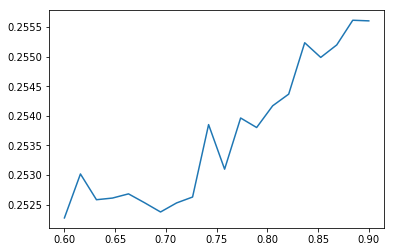

In [26]:
loss_val = [loss_num[-1] for loss_num in lvals]
plt.cla()
plt.plot(thetas,loss_val)
plt.savefig("aLund.png")

### Fitting the neural network g (DNN Model) and scan for theta with maximum loss

In [27]:
thetas = np.linspace(0.6,0.9,20)
num_data_test = 10000
predicted_weight_list = []
X_fit_replace_weight_list = []
X_val_replace_weight_list = []
for i in range(len(thetas)):
    theta = thetas[i]
    X_fit_replace_weight = replace_weight(X_fit[:num_data_test],theta)
    X_fit_replace_weight_list.append(X_fit_replace_weight)
    X_val_replace_weight = replace_weight(X_fit[-num_data_test:],theta)
    X_val_replace_weight_list.append(X_val_replace_weight)
    predicted_weight_list.append(dctr.predict(X_fit_replace_weight))

In [28]:
myinputs = Input(shape=(357,))

x = Dense(128, activation='relu')(myinputs)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=myinputs, outputs=predictions)
model.summary()

def my_loss_wrapper(weight,val=0.0):
            
    theta0 = val #target value 
    def my_loss(y_true,y_pred):
        print("y_true shape", y_true.shape)
        print("y_pred shape", y_pred.shape)
        t_loss = y_true*(y_true - y_pred)**2+(weight)*(1.-y_true)*(y_true - y_pred)**2
        return K.mean(t_loss)
        #return tf.convert_to_tensor(1.0)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 357)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               45824     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 62,465
Trainable params: 62,465
Non-trainable params: 0
_________________________________________________________________


In [29]:

lvals = []
for i in range(len(thetas)):
    print(thetas[i])
    theta = thetas[i]
    predicted_weight = predicted_weight_list[i]
    X_fit_replace_weight = X_fit_replace_weight_list[i]
    X_val_replace_weight = X_val_replace_weight_list[i]    
    model.compile(optimizer='adam', loss=my_loss_wrapper(predicted_weight[:,0]/predicted_weight[:,1],theta),metrics=['accuracy'])
    model.fit(X_fit_replace_weight.reshape(-1,357), np.argmax(Y_fit[:num_data_test],axis=1), epochs=1, batch_size=1000,validation_data=(X_val_replace_weight.reshape(-1,357), np.argmax(Y_fit[-num_data_test:],axis=1)),verbose=1)
    lvals+=[model.history.history['val_loss']]
    print
    pass
    #print(lvals) 

0.6
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 101us/step - loss: 0.2524 - acc: 0.5026 - val_loss: 0.2517 - val_acc: 0.5143
0.6157894736842106
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 97us/step - loss: 0.2508 - acc: 0.5112 - val_loss: 0.2520 - val_acc: 0.5123
0.631578947368421
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 102us/step - loss: 0.2494 - acc: 0.5223 - val_loss: 0.2521 - val_acc: 0.5106
0.6473684210526316
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 106us/step - loss: 0.2487 - acc: 0.5317 - val_loss: 0.2522 - val_acc: 0.5112
0.6631578947368421
y_true shape (

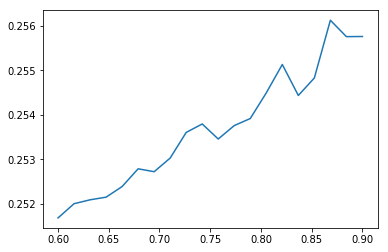

In [30]:
loss_val = [loss_num[-1] for loss_num in lvals]
plt.cla()
plt.plot(thetas,loss_val)
plt.savefig("aLund.png")

### Fitting the neural network g (DNN Model with more layers) and scan for theta with maximum loss

In [31]:
thetas = np.linspace(0.6,0.9,20)
num_data_test = 10000
predicted_weight_list = []
X_fit_replace_weight_list = []
X_val_replace_weight_list = []
for i in range(len(thetas)):
    theta = thetas[i]
    X_fit_replace_weight = replace_weight(X_fit[:num_data_test],theta)
    X_fit_replace_weight_list.append(X_fit_replace_weight)
    X_val_replace_weight = replace_weight(X_fit[-num_data_test:],theta)
    X_val_replace_weight_list.append(X_val_replace_weight)
    predicted_weight_list.append(dctr.predict(X_fit_replace_weight))

In [32]:
myinputs = Input(shape=(357,))

x = Dense(128, activation='relu')(myinputs)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=myinputs, outputs=predictions)
model.summary()

def my_loss_wrapper(weight,val=0.0):
            
    theta0 = val #target value 
    def my_loss(y_true,y_pred):
        print("y_true shape", y_true.shape)
        print("y_pred shape", y_pred.shape)
        t_loss = y_true*(y_true - y_pred)**2+(weight)*(1.-y_true)*(y_true - y_pred)**2
        return K.mean(t_loss)
        #return tf.convert_to_tensor(1.0)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 357)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               45824     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 95,489
Trainable params: 95,489
Non-trainable params: 0
_________________________________________________________________


In [33]:

lvals = []
for i in range(len(thetas)):
    print(thetas[i])
    theta = thetas[i]
    predicted_weight = predicted_weight_list[i]
    X_fit_replace_weight = X_fit_replace_weight_list[i]
    X_val_replace_weight = X_val_replace_weight_list[i]    
    model.compile(optimizer='adam', loss=my_loss_wrapper(predicted_weight[:,0]/predicted_weight[:,1],theta),metrics=['accuracy'])
    model.fit(X_fit_replace_weight.reshape(-1,357), np.argmax(Y_fit[:num_data_test],axis=1), epochs=1, batch_size=1000,validation_data=(X_val_replace_weight.reshape(-1,357), np.argmax(Y_fit[-num_data_test:],axis=1)),verbose=1)
    lvals+=[model.history.history['val_loss']]
    print
    pass
    #print(lvals) 

0.6
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 224us/step - loss: 0.2519 - acc: 0.5026 - val_loss: 0.2516 - val_acc: 0.5103
0.6157894736842106
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 213us/step - loss: 0.2510 - acc: 0.5124 - val_loss: 0.2516 - val_acc: 0.5131
0.631578947368421
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 226us/step - loss: 0.2502 - acc: 0.5227 - val_loss: 0.2518 - val_acc: 0.5029
0.6473684210526316
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 232us/step - loss: 0.2496 - acc: 0.5206 - val_loss: 0.2518 - val_acc: 0.5066
0.6631578947368421
y_true shape 

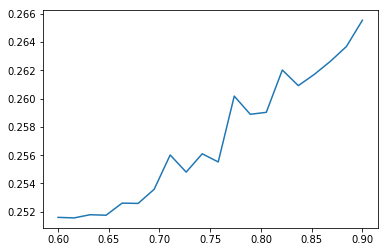

In [34]:
loss_val = [loss_num[-1] for loss_num in lvals]
plt.cla()
plt.plot(thetas,loss_val)
plt.savefig("aLund.png")

### Fitting the neural network g (PFN Models) and scan for theta with maximum loss

In [42]:
thetas = np.linspace(0.75,0.85,50)
num_data_test = 10000
predicted_weight_list = []
X_fit_replace_weight_list = []
X_val_replace_weight_list = []
for i in range(len(thetas)):
    theta = thetas[i]
    X_fit_replace_weight = replace_weight(X_fit[:num_data_test],theta)
    X_fit_replace_weight_list.append(X_fit_replace_weight)
    X_val_replace_weight = replace_weight(X_fit[-num_data_test:],theta)
    X_val_replace_weight_list.append(X_val_replace_weight)
    predicted_weight_list.append(dctr.predict(X_fit_replace_weight))

In [43]:
model = PFN(input_dim=7, 
            Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
            output_dim = 1, output_act = 'sigmoid',
            summary=False)

def my_loss_wrapper(weight,val=0.0):
            
    theta0 = val #target value 
    def my_loss(y_true,y_pred):
        print("y_true shape", y_true.shape)
        print("y_pred shape", y_pred.shape)
        t_loss = y_true*(y_true - y_pred)**2+(weight)*(1.-y_true)*(y_true - y_pred)**2
        return K.mean(t_loss)
        #return tf.convert_to_tensor(1.0)
    return my_loss

In [44]:

lvals = []
for i in range(len(thetas)):
    print(thetas[i])
    theta = thetas[i]
    predicted_weight = predicted_weight_list[i]
    X_fit_replace_weight = X_fit_replace_weight_list[i]
    X_val_replace_weight = X_val_replace_weight_list[i] 
    model.model.compile(optimizer='adam', loss=my_loss_wrapper(predicted_weight[:,1]/predicted_weight[:,0],theta),metrics=['accuracy'])
    model.fit(X_fit_replace_weight, np.argmax(Y_fit[:num_data_test],axis=1), epochs=1, batch_size=100,validation_data=(X_val_replace_weight, np.argmax(Y_fit[-num_data_test:],axis=1)),verbose=1)
    lvals+=[model.history.history['val_loss']]
    print
    pass
    #print(lvals) 

0.75
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 8s 803us/step - loss: 0.2890 - acc: 0.5040 - val_loss: 0.2538 - val_acc: 0.5122
0.7520408163265306
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 8s 826us/step - loss: 0.2582 - acc: 0.4922 - val_loss: 0.2563 - val_acc: 0.4911
0.7540816326530613
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 8s 797us/step - loss: 0.2545 - acc: 0.5102 - val_loss: 0.2521 - val_acc: 0.4935
0.7561224489795918
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 8s 825us/step - loss: 0.2528 - acc: 0.5067 - val_loss: 0.2543 - val_acc: 0.4904
0.7581632653061224
y_true shap

10000/10000 [==============================] - 9s 926us/step - loss: 0.2470 - acc: 0.5370 - val_loss: 0.2528 - val_acc: 0.5015
0.8193877551020408
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 9s 938us/step - loss: 0.2473 - acc: 0.5343 - val_loss: 0.2524 - val_acc: 0.5099
0.8214285714285714
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 9s 945us/step - loss: 0.2470 - acc: 0.5358 - val_loss: 0.2536 - val_acc: 0.5063
0.823469387755102
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 9s 950us/step - loss: 0.2467 - acc: 0.5370 - val_loss: 0.2529 - val_acc: 0.5136
0.8255102040816327
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [====

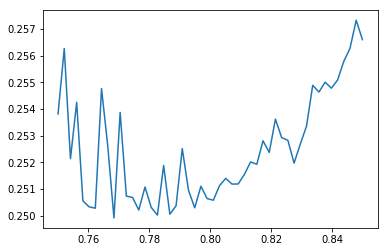

In [45]:
loss_val = [loss_num[-1] for loss_num in lvals]
plt.cla()
plt.plot(thetas,loss_val)
plt.savefig("aLund.png")

### (g,theta) fit for PFN Model

In [46]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LambdaCallback


In [92]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(". theta fit = ",model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = 0.79
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(model_fit.layers[-1].get_weights()[0]))

callbacks = [print_weights, append_fit_value]

In [93]:
PFN_model = PFN(input_dim=7, 
            Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
            output_dim = 1, output_act = 'sigmoid',
            summary=False)
myinputs_fit = PFN_model.inputs[0]

identity = Lambda(lambda x: x + 0)(PFN_model.output)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape=list(),
                                                         initializer = keras.initializers.Constant(value = theta_fit_init),
                                                         trainable=True)
model_fit.summary()

train_theta = False

num_data_test = 10000
num_val_test = int(num_data_test/5)
batch_size = 10000 #larger batch_size leads to better precision (at least for Guassian case)
epochs = 50 #but requires more epochs to train

Y_fit_train = np.argmax(Y_fit[:num_data_test],axis=1)
Y_fit_val = np.argmax(Y_fit[-num_val_test:],axis=1)
X_fit_train = X_fit[:num_data_test]
X_fit_val = X_fit[-num_val_test:]
#X_nonzero_mask = (X_fit_train[:,:,5] !=  0).reshape(num_data_test,51,1)

def my_loss_wrapper_fit(myinputs, train_theta, my_sign = 1):
    myinputs = tf.gather(tf.gather(myinputs, np.arange(batch_size)),np.arange(51), axis = 1)
    print("Shape of myinputs is", myinputs.shape)
    #Getting theta0:
    if train_theta == False:
        theta0 = model_fit.layers[-1].get_weights() #when not training theta, fetch as np array 
    else:
        theta0 = model_fit.trainable_weights[-1] #when training theta, fetch as tf.Variable
    
    #Turn [current_value,current_value,...,0,0] to [theta0,theta0,...,0,0]
    aLund_current_value = myinputs[:,:,5]
    aLund_replace_weight = tf.equal(aLund_current_value,0)
    aLund_replace_weight = (1-tf.cast(aLund_replace_weight,tf.float32))*theta0
    print(aLund_replace_weight.shape)
    #*theta0
    
    aLund_tensor = tf.reshape(aLund_replace_weight,[batch_size,51,1])
    print("Shape of aLund is", aLund_tensor)
    
    myinputs_replace_weight = K.concatenate((myinputs[:,:,:5], aLund_tensor, myinputs[:,:,6:]),axis = 2)
    
    predicted_dctr_weight = dctr.model(myinputs_replace_weight)
    weight = predicted_dctr_weight[:,1]/predicted_dctr_weight[:,0]
    
    def my_loss(y_true,y_pred):
        print("y_true shape", y_true.shape)
        print("y_pred shape", y_pred.shape)
        t_loss = my_sign*(y_true*(y_true - y_pred)**2+(weight)*(1.-y_true)*(y_true - y_pred)**2)
        return K.mean(t_loss)
    
    return my_loss


    
for k in range(epochs):  
    
    theta0 = model_fit.layers[-1].get_weights() 
    print("Theta fit value is", theta0[0])
    
    print("Epoch: ",k )
    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = True
        pass
    train_theta = False
    model_fit.layers[-1].trainable = False
    model_fit.compile(optimizer='adam', loss=my_loss_wrapper_fit(myinputs_fit, train_theta, 1),
                      metrics=['accuracy'])
    print("Training g")
    
    model_fit.fit(X_fit_train, Y_fit_train, 
                  epochs=1, batch_size=batch_size,validation_data=(X_fit_val,  Y_fit_val),
                  verbose=1,callbacks=callbacks)  
    
    #######################################################################################
    #Now, fix g and train \theta.
    
    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    model_fit.compile(optimizer='adam', loss=my_loss_wrapper_fit(myinputs_fit, train_theta, -1),
                      metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(X_fit_train, Y_fit_train, 
                  epochs=1, batch_size=batch_size,validation_data=(X_fit_val,  Y_fit_val),
                  verbose=1,callbacks=callbacks)    
    pass

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 7)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    800         input[0][0]                      
__________________________________________________________________________________________________
activation_99 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_99[0][0]              
__________________________________________________________________________________________________
activation

. theta fit =  0.79371995
Theta fit value is 0.79371995
Epoch:  5
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_395:0", shape=(10000, 51, 1), dtype=float32)
y_true shape (?, ?)
y_pred shape (?, 1)
Training g
Train on 10000 samples, validate on 2000 samples
Epoch 1/1
10000/10000 [==============================] - 39s 4ms/step - loss: 0.4137 - acc: 0.5055 - val_loss: 0.2810 - val_acc: 0.4945
. theta fit =  0.79371995
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_396:0", shape=(10000, 51, 1), dtype=float32)
y_true shape (?, ?)
y_pred shape (?, 1)
Training theta
Train on 10000 samples, validate on 2000 samples
Epoch 1/1
10000/10000 [==============================] - 38s 4ms/step - loss: -0.2890 - acc: 0.4920 - val_loss: -0.2810 - val_acc: 0.4945
. theta fit =  0.79446375
Theta fit value is 0.79446375
Epoch:  6
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_397:0", shape=(10000, 51, 1)

. theta fit =  0.8011595
Theta fit value is 0.8011595
Epoch:  15
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_415:0", shape=(10000, 51, 1), dtype=float32)
y_true shape (?, ?)
y_pred shape (?, 1)
Training g
Train on 10000 samples, validate on 2000 samples
Epoch 1/1
10000/10000 [==============================] - 41s 4ms/step - loss: 0.3645 - acc: 0.5055 - val_loss: 0.2573 - val_acc: 0.4910
. theta fit =  0.8011595
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_416:0", shape=(10000, 51, 1), dtype=float32)
y_true shape (?, ?)
y_pred shape (?, 1)
Training theta
Train on 10000 samples, validate on 2000 samples
Epoch 1/1
10000/10000 [==============================] - 40s 4ms/step - loss: -0.2650 - acc: 0.4962 - val_loss: -0.2574 - val_acc: 0.4910
. theta fit =  0.80190337
Theta fit value is 0.80190337
Epoch:  16
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_417:0", shape=(10000, 51, 1),

. theta fit =  0.8085993
Theta fit value is 0.8085993
Epoch:  25
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_435:0", shape=(10000, 51, 1), dtype=float32)
y_true shape (?, ?)
y_pred shape (?, 1)
Training g
Train on 10000 samples, validate on 2000 samples
Epoch 1/1
10000/10000 [==============================] - 71s 7ms/step - loss: 0.3145 - acc: 0.5061 - val_loss: 0.2648 - val_acc: 0.4930
. theta fit =  0.8085993
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_436:0", shape=(10000, 51, 1), dtype=float32)
y_true shape (?, ?)
y_pred shape (?, 1)
Training theta
Train on 10000 samples, validate on 2000 samples
Epoch 1/1
10000/10000 [==============================] - 44s 4ms/step - loss: -0.2728 - acc: 0.4939 - val_loss: -0.2648 - val_acc: 0.4930
. theta fit =  0.80934316
Theta fit value is 0.80934316
Epoch:  26
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_437:0", shape=(10000, 51, 1),

. theta fit =  0.81603867
Theta fit value is 0.81603867
Epoch:  35
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_455:0", shape=(10000, 51, 1), dtype=float32)
y_true shape (?, ?)
y_pred shape (?, 1)
Training g
Train on 10000 samples, validate on 2000 samples
Epoch 1/1
10000/10000 [==============================] - 53s 5ms/step - loss: 0.2931 - acc: 0.5076 - val_loss: 0.2613 - val_acc: 0.4960
. theta fit =  0.81603867
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_456:0", shape=(10000, 51, 1), dtype=float32)
y_true shape (?, ?)
y_pred shape (?, 1)
Training theta
Train on 10000 samples, validate on 2000 samples
Epoch 1/1
10000/10000 [==============================] - 53s 5ms/step - loss: -0.2686 - acc: 0.4948 - val_loss: -0.2613 - val_acc: 0.4960
. theta fit =  0.81678253
Theta fit value is 0.81678253
Epoch:  36
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_457:0", shape=(10000, 51, 

. theta fit =  0.8234777
Theta fit value is 0.8234777
Epoch:  45
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_475:0", shape=(10000, 51, 1), dtype=float32)
y_true shape (?, ?)
y_pred shape (?, 1)
Training g
Train on 10000 samples, validate on 2000 samples
Epoch 1/1
10000/10000 [==============================] - 51s 5ms/step - loss: 0.2645 - acc: 0.5093 - val_loss: 0.2825 - val_acc: 0.4930
. theta fit =  0.8234777
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_476:0", shape=(10000, 51, 1), dtype=float32)
y_true shape (?, ?)
y_pred shape (?, 1)
Training theta
Train on 10000 samples, validate on 2000 samples
Epoch 1/1
10000/10000 [==============================] - 51s 5ms/step - loss: -0.2858 - acc: 0.4948 - val_loss: -0.2825 - val_acc: 0.4930
. theta fit =  0.8242215
Theta fit value is 0.8242215
Epoch:  46
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_477:0", shape=(10000, 51, 1), d

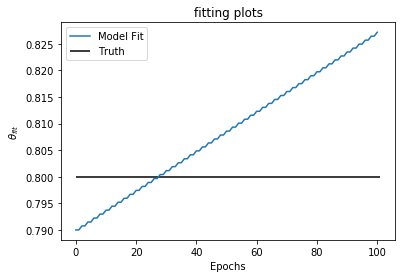

In [95]:
plt.plot(fit_vals, label='Model Fit')
plt.hlines(0.80, 0, len(fit_vals), label = 'Truth')
plt.xlabel("Epochs")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
plt.title("fitting plots")
plt.show()

### (g,theta) fit for DNN Model

In [46]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LambdaCallback


In [85]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(". theta fit = ",model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = 0.79
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(model_fit.layers[-1].get_weights()[0]))

callbacks = [print_weights, append_fit_value]

myinputs = Input(shape=(357,))
x = Dense(20, activation='relu')(myinputs)
x = Dense(20, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
dnn_model = Model(inputs=myinputs, outputs=predictions)
dnn_model.summary()

myinputs_fit = dnn_model.inputs[0]
identity = Lambda(lambda x: x + 0)(dnn_model.output)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape=list(),
                                                         initializer = keras.initializers.Constant(value = theta_fit_init),
                                                         trainable=True)
model_fit.summary()

train_theta = False

num_data_test = 10000
num_val_test = int(num_data_test/5)
batch_size = 10000 #larger batch_size leads to better precision (at least for Guassian case)
epochs = 20 #but requires more epochs to train

Y_fit_train = np.argmax(Y_fit[:num_data_test],axis=1)
Y_fit_val = np.argmax(Y_fit[-num_val_test:],axis=1)
X_fit_train = X_fit[:num_data_test].reshape(-1,357)
X_fit_val = X_fit[-num_val_test:].reshape(-1,357)
#X_nonzero_mask = (X_fit_train[:,:,5] !=  0).reshape(num_data_test,51,1)

def my_loss_wrapper_fit(myinputs, train_theta, my_sign = 1):
    myinputs = tf.gather(myinputs, np.arange(batch_size))
    myinputs = tf.reshape(myinputs, [batch_size,51,7])
    print("Shape of myinputs is", myinputs.shape)
    #Getting theta0:
    if train_theta == False:
        theta0 = model_fit.layers[-1].get_weights() #when not training theta, fetch as np array 
    else:
        theta0 = model_fit.trainable_weights[-1] #when training theta, fetch as tf.Variable
    
    #Turn [current_value,current_value,...,0,0] to [theta0,theta0,...,0,0]
#     aLund_current_value = myinputs[:,:,5]
#     aLund_replace_weight = tf.equal(aLund_current_value,0)
#     aLund_replace_weight = (1-tf.cast(aLund_replace_weight,tf.float32))*theta0
    
    aLund_current_value = myinputs[:,:,5]
    aLund_replace_weight = tf.equal(aLund_current_value,0)
    aLund_replace_weight = (1-tf.cast(aLund_replace_weight,tf.float32))*theta0
    print(aLund_replace_weight.shape)
    #*theta0
    
    aLund_tensor = tf.reshape(aLund_replace_weight,[batch_size,51,1])
    print("Shape of aLund is", aLund_tensor)
    
    myinputs_replace_weight = K.concatenate((myinputs[:,:,:5], aLund_tensor, myinputs[:,:,6:]),axis = 2)
    #myinputs_replace_weight = myinputs
    
    predicted_dctr_weight = dctr.model(myinputs_replace_weight)
    weight = predicted_dctr_weight[:,1]/predicted_dctr_weight[:,0]
    
    def my_loss(y_true,y_pred):
        print("y_true shape", y_true.shape)
        print("y_pred shape", y_pred.shape)
        t_loss = my_sign*(y_true*(y_true - y_pred)**2+(weight)*(1.-y_true)*(y_true - y_pred)**2)
        return K.mean(t_loss)
    
    return my_loss


    
for k in range(epochs):  
    
    theta0 = model_fit.layers[-1].get_weights() 
    print("Theta fit value is", theta0[0])
    
    print("Epoch: ",k )
    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = True
        pass
    train_theta = False
    model_fit.layers[-1].trainable = False
    model_fit.compile(optimizer='adam', loss=my_loss_wrapper_fit(myinputs_fit, train_theta, 1),
                      metrics=['accuracy'])
    print("Training g")
    
    model_fit.fit(X_fit_train, Y_fit_train, 
                  epochs=1, batch_size=batch_size,validation_data=(X_fit_val,  Y_fit_val),
                  verbose=1,callbacks=callbacks)  
    
    #######################################################################################
    #Now, fix g and train \theta.
    
    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    model_fit.compile(optimizer='adam', loss=my_loss_wrapper_fit(myinputs_fit, train_theta, -1),
                      metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(X_fit_train, Y_fit_train, 
                  epochs=1, batch_size=batch_size,validation_data=(X_fit_val,  Y_fit_val),
                  verbose=1,callbacks=callbacks)    
    pass

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 357)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 20)                7160      
_________________________________________________________________
dense_117 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_118 (Dense)            (None, 1)                 21        
Total params: 7,601
Trainable params: 7,601
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 357)               0         
_________________________________________________________________
dense_11

Train on 10000 samples, validate on 2000 samples
Epoch 1/1
10000/10000 [==============================] - 29s 3ms/step - loss: -0.2496 - acc: 0.5163 - val_loss: -0.2381 - val_acc: 0.5055
. theta fit =  0.79595166
Theta fit value is 0.79595166
Epoch:  8
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_314:0", shape=(10000, 51, 1), dtype=float32)
y_true shape (?, ?)
y_pred shape (?, 1)
Training g
Train on 10000 samples, validate on 2000 samples
Epoch 1/1
10000/10000 [==============================] - 29s 3ms/step - loss: 0.2497 - acc: 0.5163 - val_loss: 0.2380 - val_acc: 0.5030
. theta fit =  0.79595166
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_316:0", shape=(10000, 51, 1), dtype=float32)
y_true shape (?, ?)
y_pred shape (?, 1)
Training theta
Train on 10000 samples, validate on 2000 samples
Epoch 1/1
10000/10000 [==============================] - 29s 3ms/step - loss: -0.2495 - acc: 0.5175 - val_loss: -0.2380 - val_a

Train on 10000 samples, validate on 2000 samples
Epoch 1/1
10000/10000 [==============================] - 27s 3ms/step - loss: -0.2486 - acc: 0.5298 - val_loss: -0.2379 - val_acc: 0.5050
. theta fit =  0.8033915
Theta fit value is 0.8033915
Epoch:  18
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_354:0", shape=(10000, 51, 1), dtype=float32)
y_true shape (?, ?)
y_pred shape (?, 1)
Training g
Train on 10000 samples, validate on 2000 samples
Epoch 1/1
10000/10000 [==============================] - 28s 3ms/step - loss: 0.2486 - acc: 0.5298 - val_loss: 0.2380 - val_acc: 0.5040
. theta fit =  0.8033915
Shape of myinputs is (10000, 51, 7)
(10000, 51)
Shape of aLund is Tensor("Reshape_356:0", shape=(10000, 51, 1), dtype=float32)
y_true shape (?, ?)
y_pred shape (?, 1)
Training theta
Train on 10000 samples, validate on 2000 samples
Epoch 1/1
10000/10000 [==============================] - 28s 3ms/step - loss: -0.2485 - acc: 0.5276 - val_loss: -0.2380 - val_acc

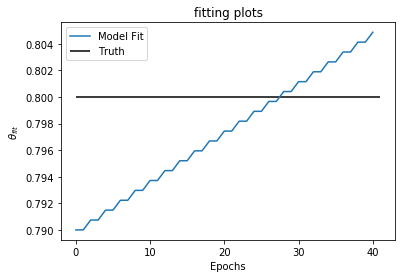

In [86]:
plt.plot(fit_vals, label='Model Fit')
plt.hlines(0.80, 0, len(fit_vals), label = 'Truth')
plt.xlabel("Epochs")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
plt.title("fitting plots")
plt.show()